<a href="https://colab.research.google.com/github/KM-Footy/fot-valuing-actions/blob/master/FCBarcelona_lda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install socceraction==0.2.0

In [2]:
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)
from pandas import json_normalize
import tqdm

import socceraction.spadl as spadl
import socceraction.vaep.features as fs
import socceraction.spadl.statsbomb as statsbomb

import seaborn as sns
import matplotlib.pyplot as plt

import gensim
from gensim import models,corpora

In [3]:
free_open_data_remote = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
SBL = statsbomb.StatsBombLoader(root=free_open_data_remote,getter="remote")
comp = SBL.competitions()
comp.competition_name.value_counts()

La Liga                    17
Champions League           15
FA Women's Super League     3
Premier League              1
FIFA World Cup              1
NWSL                        1
UEFA Euro                   1
Women's World Cup           1
Name: competition_name, dtype: int64

In [ ]:
selectedcomp = comp[comp['competition_name'] == 'La Liga']
matches = list(
    SBL.matches(row.competition_id, row.season_id)
    for row in selectedcomp.itertuples()
)
matches = pd.concat(matches, sort=True).reset_index(drop=True)
print(matches.columns)

In [5]:
matches['season_name'].unique()

array(['2020/2021', '2019/2020', '2018/2019', '2017/2018', '2016/2017',
       '2015/2016', '2014/2015', '2013/2014', '2012/2013', '2011/2012',
       '2010/2011', '2009/2010', '2008/2009', '2007/2008', '2006/2007',
       '2005/2006', '2004/2005'], dtype=object)

In [34]:
matches = matches[matches['season_name']=='2018/2019']
matches.head()

,away_score,away_team_gender,away_team_group,away_team_id,away_team_name,competition_id,competition_name,country_name,data_version,home_score,home_team_gender,home_team_group,home_team_id,home_team_name,id,kick_off,last_updated,last_updated_360,managers,match_date,match_id,match_status,match_status_360,match_week,name,season_id,season_name,shot_fidelity_version,xy_fidelity_version
68,1,male,None,217,Barcelona,11,La Liga,Spain,1.1.0,2,male,None,205,Leganés,112,20:00:00.000,2020-07-29T05:00,2021-06-13T16:17:31.694,"[{'id': 227, 'name': 'Ernesto Valverde Tejedor...",2018-09-26,15998,available,scheduled,6,Italy,4,2018/2019,2,NaN
69,2,male,None,213,Sevilla,11,La Liga,Spain,1.1.0,4,male,None,217,Barcelona,214,20:45:00.000,2020-07-29T05:00,2021-06-13T16:17:31.694,"[{'id': 234, 'name': 'Pablo Javier Machín Díez...",2018-10-20,16029,available,scheduled,9,Spain,4,2018/2019,2,NaN
70,1,male,None,217,Barcelona,11,La Liga,Spain,1.1.0,1,male,None,212,Atlético Madrid,214,20:45:00.000,2020-07-29T05:00,2021-06-13T16:17:31.694,"[{'id': 227, 'name': 'Ernesto Valverde Tejedor...",2018-11-24,16073,available,scheduled,13,Spain,4,2018/2019,2,NaN
71,4,male,None,217,Barcelona,11,La Liga,Spain,1.1.0,0,male,None,214,Espanyol,214,20:45:00.000,2020-07-29T05:00,2021-06-13T16:17:31.694,"[{'id': 227, 'name': 'Ernesto Valverde Tejedor...",2018-12-08,16086,available,scheduled,15,Spain,4,2018/2019,2,NaN
72,4,male,None,217,Barcelona,11,La Liga,Spain,1.1.0,2,male,None,213,Sevilla,214,16:15:00.000,2020-07-29T05:00,2021-06-13T16:17:31.694,"[{'id': 227, 'name': 'Ernesto Valverde Tejedor...",2019-02-23,16190,available,scheduled,25,Spain,4,2018/2019,2,NaN


In [38]:
def load_play_data():
    matches_verbose = tqdm.tqdm(list(matches.itertuples()),desc="Loading match data")
    teams,players,player_games = [],[],[]
    actions = {}
    for match in matches_verbose:
        teams.append(SBL.teams(match.match_id))
        players.append(SBL.players(match.match_id))
        events = SBL.events(match.match_id)

        player_games.append(statsbomb.extract_player_games(events))
        actions[match.match_id] = statsbomb.convert_to_actions(events,match.home_team_id)

    players = pd.concat(players).drop_duplicates("player_id").reset_index(drop=True)
    players['player'] = players[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
    games = matches.rename(columns={"match_id":"game_id"})
    teams = pd.concat(teams).drop_duplicates("team_id").reset_index(drop=True)


    player_dict = dict(players.set_index('player_id')['player'])
    home_team_dict = dict(games.set_index('game_id')['home_team_name'])
    team_dict = dict(teams.set_index('team_id')['team_name'])

    return actions,player_dict,home_team_dict,team_dict,games
actions,player_dict,home_team_dict,team_dict,games = load_play_data()

Loading match data: 100%|██████████| 34/34 [00:22<00:00,  1.49it/s]


In [39]:
def get_dict():
    actiontypes= spadl.actiontypes_df()
    results= spadl.results_df()
    bodyparts= spadl.bodyparts_df()

    actiontype_dict = dict(actiontypes.set_index('type_id')['type_name'])
    result_dict = dict(results.set_index('result_id')['result_name'])
    bodypart_dict = dict(bodyparts.set_index('bodypart_id')['bodypart_name'])

    return actiontype_dict,result_dict,bodypart_dict

actiontype_dict,result_dict,bodypart_dict = get_dict()

print(f"- actiontype_dict:\n{actiontype_dict}\n")
print(f"- result_dict:\n{result_dict}\n")
print(f"- bodypart_dict:\n{bodypart_dict}\n")

- actiontype_dict:
{0: 'pass', 1: 'cross', 2: 'throw_in', 3: 'freekick_crossed', 4: 'freekick_short', 5: 'corner_crossed', 6: 'corner_short', 7: 'take_on', 8: 'foul', 9: 'tackle', 10: 'interception', 11: 'shot', 12: 'shot_penalty', 13: 'shot_freekick', 14: 'keeper_save', 15: 'keeper_claim', 16: 'keeper_punch', 17: 'keeper_pick_up', 18: 'clearance', 19: 'bad_touch', 20: 'non_action', 21: 'dribble', 22: 'goalkick'}

- result_dict:
{0: 'fail', 1: 'success', 2: 'offside', 3: 'owngoal', 4: 'yellow_card', 5: 'red_card'}

- bodypart_dict:
{0: 'foot', 1: 'head', 2: 'other'}



In [40]:
def create_dataset(df):
    df['player'] = df['player_id'].map(player_dict)
    df['team_name'] = df['team_id'].map(team_dict)
    df['home_team_name'] = df['game_id'].map(home_team_dict)

    df['type'] =  df['type_id'].map(actiontype_dict)
    df['result'] = df['result_id'].map(result_dict)
    df['bodypart'] = df['bodypart_id'].map(bodypart_dict)
    df = df.loc[df.period_id != 5,
                      ['game_id','period_id','time_seconds','team_name','home_team_name','player','start_x','start_y','bodypart','type','result']]
    return df

all_df = pd.DataFrame([])
for i in tqdm.tqdm(actions.keys()):
    tmp = create_dataset(actions[i])
    all_df = pd.concat([all_df,tmp],ignore_index=True)

100%|██████████| 34/34 [00:00<00:00, 48.76it/s]


In [46]:
 all_df[11500:11520]

,game_id,period_id,time_seconds,team_name,home_team_name,player,start_x,start_y,bodypart,type,result
11500,16109,1,688.0,Celta Vigo,Barcelona,Brais Méndez,68.823529,48.202532,foot,pass,success
11501,16109,1,690.0,Celta Vigo,Barcelona,Iago Aspas,56.470588,54.227848,foot,dribble,success
11502,16109,1,693.0,Celta Vigo,Barcelona,Iago Aspas,37.941176,66.278481,foot,bad_touch,fail
11503,16109,1,704.0,Barcelona,Barcelona,Jordi Alba,37.941176,68.000000,foot,throw_in,success
11504,16109,1,709.0,Barcelona,Barcelona,Ivan Rakitić,39.705882,43.898734,foot,pass,success
11505,16109,1,712.0,Barcelona,Barcelona,Nélson Semedo,48.529412,6.025316,foot,dribble,success
11506,16109,1,715.0,Barcelona,Barcelona,Nélson Semedo,43.235294,6.886076,foot,pass,success
11507,16109,1,717.0,Barcelona,Barcelona,Gerard Piqué,37.058824,17.215190,foot,dribble,success
11508,16109,1,718.0,Barcelona,Barcelona,Gerard Piqué,37.941176,18.075949,foot,pass,success
11509,16109,1,719.0,Barcelona,Barcelona,Ivan Rakitić,47.647059,35.291139,foot,dribble,success


In [11]:
all_df['home_team_name'].unique()

array(['Leganés', 'Barcelona', 'Sevilla', 'Atlético Madrid', 'Espanyol',
       'Celta Vigo', 'Getafe', 'Real Valladolid', 'Real Betis',
       'Athletic Club', 'Real Sociedad', 'Deportivo Alavés', 'Valencia',
       'Levante', 'Villarreal', 'Girona', 'Huesca', 'Eibar',
       'Rayo Vallecano', 'Real Madrid'], dtype=object)

In [47]:
barca_df = all_df[(all_df.team_name=='Barcelona')].reset_index(drop = True)

barca_df['start_x_trim'] = (np.floor(barca_df['start_x']/5)*5).astype(int)
barca_df['start_y_trim'] = (np.floor(barca_df['start_y']/5)*5).astype(int)

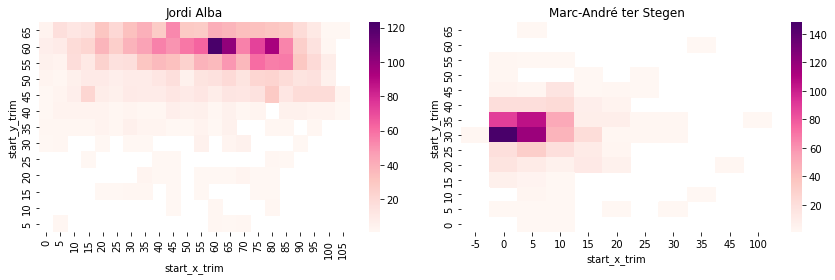

In [48]:
plt.rc('figure',figsize=[12,4])
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False,sharey = False)

sns.heatmap(barca_df[(barca_df.home_team_name=='Barcelona')&(barca_df.player=='Jordi Alba')].pivot_table(
    index='start_y_trim',columns='start_x_trim',values = 'player',aggfunc = "count").sort_index(ascending = False),cmap = "RdPu",ax=axes[0])
axes[0].set_title('Jordi Alba')

sns.heatmap(barca_df[(barca_df.home_team_name=='Barcelona')&(barca_df.player=='Marc-André ter Stegen')].pivot_table(
    index='start_y_trim',columns='start_x_trim',values = 'player',aggfunc = "count").sort_index(ascending = False),cmap = "RdPu",ax=axes[1])
axes[1].set_title('Marc-André ter Stegen')

plt.tight_layout()

In [49]:
def convert_away(df):
    df.loc[df.team_name != df.home_team_name,'start_x'] = np.abs(df['start_x']-105)
    df.loc[df.team_name != df.home_team_name,'start_y'] = np.abs(df['start_y']-68)
    return df
all_df = convert_away(all_df)

In [50]:
def round_xy(df):
    df['start_x'] = (np.floor(df['start_x']/5)*5).astype(int)
    df['start_y'] = (np.floor(df['start_y']/5)*5).astype(int)
    return df
all_df = round_xy(all_df)

In [51]:
def merge_xy(df):
    df['start_xy'] = df.apply(lambda x:(str(x['start_x'])+"_"+str(x['start_y'])),axis=1)
    return df

all_df= merge_xy(all_df)

In [52]:
all_df_pivot = all_df.pivot_table(index = ['team_name','player','game_id'],columns = 'start_xy',
                                  values = 'period_id',aggfunc = 'count',fill_value=0)
all_df_pivot.head()

start_xy                                -5_30  -5_35  0_0  ...  95_55  95_60  95_65
team_name     player           game_id                     ...                     
Athletic Club Aritz Aduriz     16010        0      0    0  ...      0      0      0
              Beñat Etxebarria 16010        0      0    0  ...      0      0      0
                               16173        0      0    0  ...      0      0      0
              Dani García      16010        0      0    0  ...      0      0      0
                               16173        0      0    0  ...      0      0      0

[5 rows x 308 columns]

In [53]:
X = np.array(all_df_pivot, dtype=np.int16)
corpus = gensim.matutils.Dense2Corpus(X.T)
vocab = list(all_df_pivot.columns)
dictionary = corpora.Dictionary([vocab])

In [54]:
topic_num = 11
LDA = models.LdaMulticore(corpus,num_topics=topic_num,id2word=dictionary,
                          iterations=100,
                          passes=20,
                          minimum_probability=0.01,
                          random_state = 42,
                          workers=32)

In [55]:
def check_topic(LDA):
    topic_tags = []
    for topic in LDA.show_topics(num_topics=11,num_words=5,formatted=False):
        topic_tags.append([tag[0] for tag in topic[1]])
    topic_app = pd.DataFrame(topic_tags).T
    topic_app.columns = [f"topic_{i:02}" for i in topic_app.columns ]
    return topic_app
topic_app = check_topic(LDA)
topic_app

,topic_00,topic_01,topic_02,topic_03,topic_04,topic_05,topic_06,topic_07,topic_08,topic_09,topic_10
0,60_60,60_55,70_10,0_30,50_30,35_30,45_30,20_45,65_45,65_0,45_20
1,65_60,50_55,65_15,5_30,85_45,35_35,60_35,30_45,65_50,60_0,45_15
2,75_60,45_55,75_15,0_35,95_45,40_30,65_35,35_50,65_55,55_0,40_15
3,80_60,55_55,65_10,5_35,80_45,30_30,60_25,45_45,60_45,65_5,35_15
4,45_60,55_50,80_15,10_30,90_40,45_35,45_35,35_45,75_45,75_0,40_20


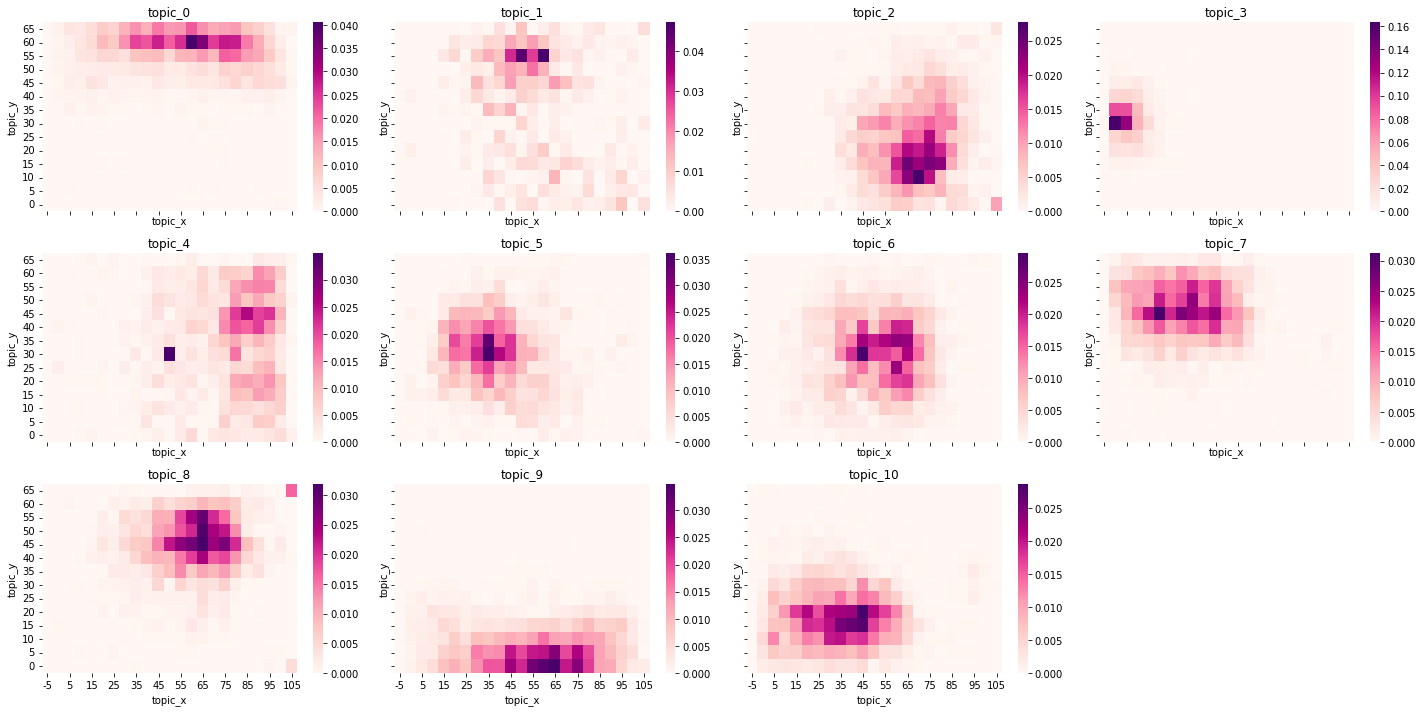

In [56]:
topic_df = pd.DataFrame([])
for i in range(topic_num):
    tmp = pd.DataFrame(LDA.show_topic(i, topn=425),columns=['topic_vocab','prob'])
    tmp['topic_id'] = i
    topic_df = pd.concat([topic_df,tmp],ignore_index=True)
topic_df = topic_df[['topic_id','topic_vocab','prob']]
topic_df['topic_x'] = topic_df['topic_vocab'].apply(lambda x :x.split('_')[0])
topic_df['topic_y'] = topic_df['topic_vocab'].apply(lambda x :x.split('_')[1])
topic_df['topic_x'] = topic_df['topic_x'].astype(int)
topic_df['topic_y'] = topic_df['topic_y'].astype(int)

key_list = [
        np.sort(topic_df['topic_id'].unique()),
        np.sort(all_df['start_x'].unique()),
        np.sort(all_df['start_y'].unique())
    ]
master_table = pd.DataFrame(
        index = pd.MultiIndex.from_product(
            key_list
        )
    ).reset_index()
master_table.columns = ['topic_id','topic_x','topic_y']

topic_all = pd.merge(master_table,topic_df[['topic_id','topic_x','topic_y','prob']],how = 'left',on = ['topic_id','topic_x','topic_y'])
topic_all['prob'] = topic_all['prob'].fillna(0)

plt.rc('figure',figsize=[20,10])
fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True,sharey = True)
for i in range(11):
    sns.heatmap(topic_all[topic_all.topic_id==i].pivot_table(
        index='topic_y',columns='topic_x',values = 'prob',aggfunc = "sum").sort_index(ascending = False),cmap = "RdPu",ax=axes[i//4,i%4])
    axes[i//4,i%4].set_title(f'topic_{i}')
    axes[2,3].axis("off")
plt.tight_layout()

In [57]:
tmps = []
for i in tqdm.tqdm(range(X.T.shape[1])):
    Topic_prob = [l[1] for l in LDA.get_document_topics(gensim.matutils.dense2vec(X.T[:,i]),minimum_probability=0)]
    tmps.append(Topic_prob)
df = pd.DataFrame(tmps)
df.index = all_df_pivot.index
df.columns = ['topic_{0:02d}'.format(l) for l in range(topic_num)]
df['top_topic'] = df.idxmax(axis=1)

100%|██████████| 947/947 [00:00<00:00, 1433.10it/s]


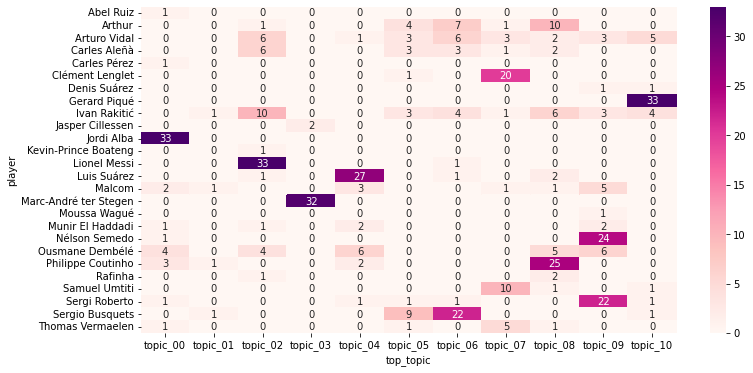

In [58]:
player_topic = df['top_topic'].reset_index()
player_topic_barca = player_topic[player_topic['team_name']=='Barcelona'].reset_index(drop = True)
plt.rc('figure',figsize=[12,6])
sns.heatmap(player_topic_barca.pivot_table(
    index = 'player',columns = 'top_topic',values='game_id',aggfunc = 'count',fill_value= 0),cmap = "RdPu",annot=True)